In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [5]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. Обязательная часть(=ДЗ2): Провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи (Визуализировать, чтобы понять как это влияет на таргет. Главное - сформировать гипотезу - Если произошло событие N клиент после этого оттечет. И проверить ее на данных. Результат - работающая фича.)
5. Обязательная часть(=ДЗ4 с семинара 5): Отобрать важные фичи (увеличивают метрику на тесте) и обучить модель, попробовать подобрать гипперпараметры (Тип алгоритма - Случайный лес). Метрика оценки качества - ROC AUC.

Совет: документировать в удобно формате (я делаю в экселе):
- Параметры - Тип и гиперпараметры модели - Метрику (чтобы анализировать ход работы)
    

## Практика

In [6]:
raw_df.describe()

,cl_id,MCC,currency,amount,target_flag,target_sum
count,490513.000000,490513.000000,490513.000000,4.905130e+05,490513.000000,4.905130e+05
mean,4802.127361,5699.783822,810.601854,5.723594e+03,0.652588,1.627345e+05
std,2986.492835,662.933380,38.223123,7.703763e+04,0.476148,1.474097e+06
min,0.000000,742.000000,32.000000,4.000000e-02,0.000000,0.000000e+00
25%,2193.000000,5411.000000,810.000000,2.240000e+02,0.000000,0.000000e+00
50%,4576.000000,5661.000000,810.000000,6.240000e+02,1.000000,2.491009e+04
75%,7390.000000,5941.000000,810.000000,2.176000e+03,1.000000,1.516193e+05
max,10215.000000,9405.000000,986.000000,3.583500e+07,1.000000,4.606578e+07


In [7]:
# посмотрим на статистики для категориальных значений 
raw_df.describe(include=['object'])

,PERIOD,channel_type,TRDATETIME,trx_category
count,490513,487603,490513,490513
unique,19,5,58113,10
top,01/07/2017,type1,23JUN17:00:00:00,POS
freq,55757,299247,1971,416425


In [8]:
# посмотрим на MCC как на категорию
print('mode', raw_df['MCC'].mode())

print('unique', len(raw_df.MCC.unique()))

# это категория 	Бакалейные магазины, супермаркеты

#Источник: https://mcc-codes.ru/code

mode 0    5411
dtype: int64
unique 344


In [9]:
# посмотрим на currency как на категорию
print('mode', raw_df['currency'].mode())

print('unique', len(raw_df.currency.unique()))

# 810 - это рубль

mode 0    810
dtype: int64
unique 59


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B3B1F7FA58>,
      dtype=object)

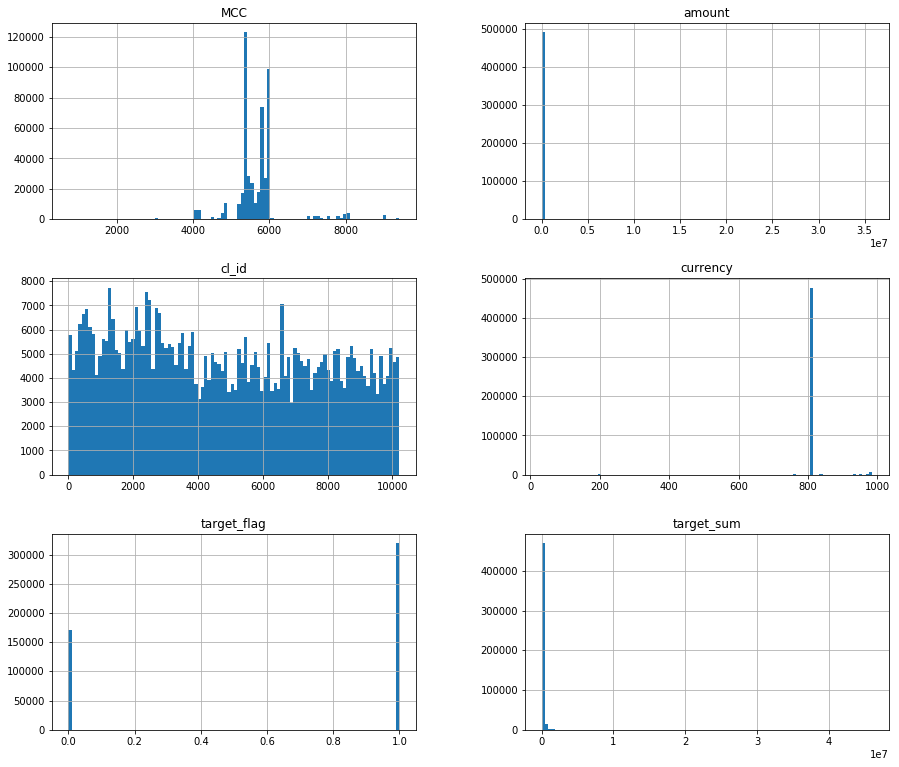

In [12]:
# распределения
raw_df.hist(bins=100, figsize=(15,13))

In [10]:
import seaborn as sns

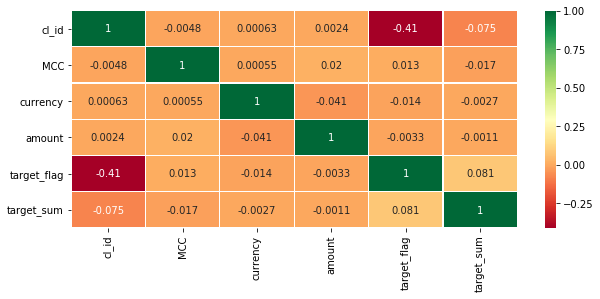

In [11]:
sns.heatmap(raw_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,4)
plt.show()

есть небольшая отриц корр по cl_id. 
cl_id присваивается в хронологиеском порядке.

In [12]:
def missingdata(raw_df):
    '''
    считаем кол-во и долю пропущеных значений
    '''
    total = raw_df.isnull().sum().sort_values(ascending = False)
    percent = (raw_df.isnull().sum()/raw_df.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    return ms

In [13]:
missingdata(raw_df)

,Total,Percent
channel_type,2910,0.593256


In [14]:
t_channel = raw_df.groupby(['channel_type']).count()['target_flag'].reset_index()

t_channel['percent'] = t_channel['target_flag'] / raw_df['channel_type'].count() *100

print(t_channel)

  channel_type  target_flag    percent
0        type1       299247  61.371033
1        type2       175013  35.892519
2        type3         3280   0.672678
3        type4         4476   0.917960
4        type5         5587   1.145809


In [15]:
# смотрим как распределены пропуски по целевой переменной
raw_df[raw_df.channel_type.isnull()].groupby('target_flag').count()['currency']

# примерно 50/50

target_flag
0    1627
1    1283
Name: currency, dtype: int64

In [16]:
channel_target = raw_df.groupby(['channel_type', 'target_flag']).count()['currency']
channel_target

channel_type  target_flag
type1         0              145779
              1              153468
type2         0               19717
              1              155296
type3         0                1017
              1                2263
type4         0                1026
              1                3450
type5         0                1244
              1                4343
Name: currency, dtype: int64

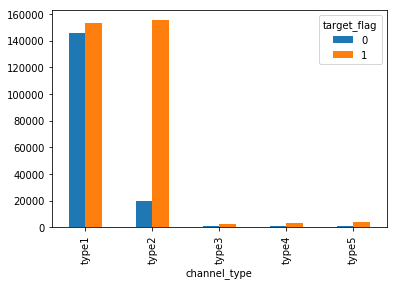

In [17]:
# видим, что для type1 кол-во отказов к продолжению 50/50
channel_target.unstack().plot(kind='bar')

#### type1 это так же мода, поэтому пропуски можно заполнить этим значением

In [18]:
raw_df['channel_type'].fillna(raw_df['channel_type'].mode()[0], inplace = True)

In [19]:
missingdata(raw_df)

,Total,Percent


Посмотрим распределение по target_flag по cl_id

In [20]:
cl_id_unique=raw_df.groupby(['target_flag', 'cl_id']).count()['amount'].reset_index()

In [21]:
cl_id_unique.groupby(['target_flag']).count()
# примерно 50/50

,cl_id,amount
target_flag,,
0,2233,2233
1,2767,2767


#### type2 имеет значительно меньшее кол-во отказов по сравнению с type1.
Принадлежность к type2 снижает вероятность отказа по сравнению к 1
также видно 3 группы по частоте появления type: type1, type2 и type3-5
Преобразуем данный категориальный атрибут в частотный

In [22]:
prob_type = (raw_df[raw_df['target_flag'] == 1]['channel_type'].value_counts())/(raw_df['channel_type'].value_counts())

In [23]:
prob_type

type1    0.512154
type2    0.887340
type3    0.689939
type4    0.770777
type5    0.777340
Name: channel_type, dtype: float64

In [24]:
def channel_cat(data):
    '''
    заполняем значения type
    '''
    if data == 'type1':
        return prob_type[0]
    elif data == 'type2': 
        return prob_type[1]
    elif data == 'type3':
        return prob_type[2]
    elif data == 'type4':
        return prob_type[3]
    elif data == 'type5':
        return prob_type[4]
    else:
        return 0

In [25]:
raw_df['channel_type_new'] = raw_df['channel_type'].apply(channel_cat)

In [26]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,channel_type_new
0,01/10/2017,0,5200,type1,810,21OCT17:00:00:00,5023.0,POS,0,0.0,0.512154
1,01/10/2017,0,6011,type1,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,0.512154
2,01/12/2017,0,5921,type1,810,05DEC17:00:00:00,767.0,POS,0,0.0,0.512154
3,01/10/2017,0,5411,type1,810,21OCT17:00:00:00,2031.0,POS,0,0.0,0.512154
4,01/10/2017,0,6012,type1,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,0.512154


In [27]:
missingdata(raw_df)

,Total,Percent


In [ ]:
#MCC

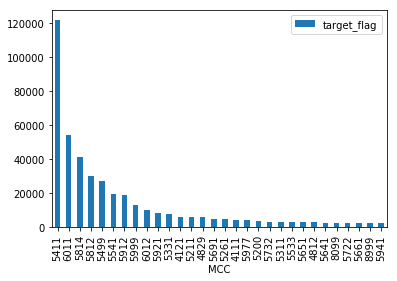

In [28]:
raw_df.groupby(['MCC']).count()[['target_flag']].sort_values('target_flag', ascending=False).head(30).plot(kind='bar')

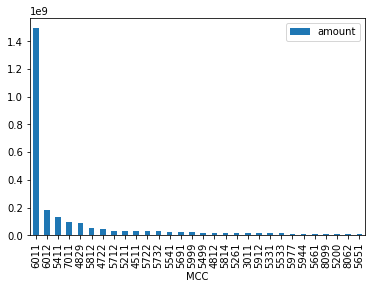

In [29]:
raw_df.groupby(['MCC']).sum()[['amount']].sort_values('amount', ascending=False).head(30).plot(kind='bar')

Сравним группировки по ко-ву и по сумме
Выделим 5 лидеров в каждой группе
1 - 5411 / 6011
2 - 6011 / 6012
3 - 5814 / 5411
4 - 5812  / 7011
5 - 5499 / 4829

Источник: https://mcc-codes.ru/code


In [ ]:
# проверим МСС по уникальным пользователям с флагом 1 и 0

In [30]:
MCC_target_1 = raw_df[(raw_df['target_flag'] == 1)].groupby(['cl_id', 'MCC']).sum().reset_index()
MCC_target_1.groupby(['MCC']).sum().sort_values('amount', ascending=False)

,cl_id,currency,amount,target_flag,target_sum,channel_type_new
MCC,,,,,,
6011,9767391,28749869,8.807829e+08,35524,7.759816e+09,25759.640732
6012,5060720,4623840,1.090293e+08,5709,1.099443e+09,3965.697964
5411,10353712,61022425,8.874367e+07,75343,1.394724e+10,52477.796573
7011,2422877,1434321,8.277692e+07,1767,5.035547e+08,1248.972669
4829,2528629,3018060,5.645994e+07,3726,6.466211e+08,2526.481423
5812,7795924,17609893,4.478597e+07,21741,6.200775e+09,15497.517807
4722,1289825,402241,3.644928e+07,494,1.312530e+08,333.696891
5211,3460177,2972727,1.951725e+07,3668,1.626244e+09,2481.218687
4511,1883834,955768,1.930900e+07,1177,3.187385e+08,821.794760


In [31]:
MCC_target_2 = raw_df[(raw_df['target_flag'] == 0)].groupby(['cl_id', 'MCC']).sum().reset_index()
MCC_target_2.groupby(['MCC']).sum().sort_values('amount', ascending=False)

,cl_id,currency,amount,target_flag,target_sum,channel_type_new
MCC,,,,,,
6011,12161186,15275643,6.132168e+08,0,0.0,10725.708286
6012,6754862,3516895,7.589818e+07,0,0.0,2423.916521
5411,11454469,37545801,4.592637e+07,0,0.0,25616.221854
4829,2374928,2008070,3.316846e+07,0,0.0,1370.926954
5712,2949544,837248,1.313314e+07,0,0.0,561.598955
4812,3072215,1254919,1.227811e+07,0,0.0,820.125001
5722,3538338,907360,1.179265e+07,0,0.0,617.661996
5732,3901122,1129704,1.176046e+07,0,0.0,810.653062
7011,1698403,529765,1.164760e+07,0,0.0,389.660028


Профиль по суммам
0
5712 - мебель
4812 - продажа телефонов
5722 - быт. оборудование
5732 - эл. оборудование

1
5812 - рестораны
4722 - туризм
4511 - авиа

В дальнейшем создадим МСС_ где просуммируем dummies по профилю 0

In [32]:
def mcc_cat(data):
    '''
    заполняем значения MCC для флага = 0
    '''
    if data == 5712:
        return 5712
    elif data == 4812: 
        return 4812
    elif data == 5722:
        return 5722
    elif data == 5732:
        return 5732
    else:
        return 7000

In [33]:
raw_df['MCC_new'] = raw_df['MCC'].apply(mcc_cat)

In [34]:

raw_df = pd.get_dummies(raw_df, columns = ["MCC_new"],prefix=["MCC_new"])

raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,channel_type_new,MCC_new_4812,MCC_new_5712,MCC_new_5722,MCC_new_5732,MCC_new_7000
0,01/10/2017,0,5200,type1,810,21OCT17:00:00:00,5023.0,POS,0,0.0,0.512154,0,0,0,0,1
1,01/10/2017,0,6011,type1,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,0.512154,0,0,0,0,1
2,01/12/2017,0,5921,type1,810,05DEC17:00:00:00,767.0,POS,0,0.0,0.512154,0,0,0,0,1
3,01/10/2017,0,5411,type1,810,21OCT17:00:00:00,2031.0,POS,0,0.0,0.512154,0,0,0,0,1
4,01/10/2017,0,6012,type1,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,0.512154,0,0,0,0,1


In [35]:
# зависимость от сумму транзакций
amount_target_1 = raw_df[(raw_df['target_flag'] == 1)].groupby(['cl_id']).sum()['amount'].reset_index()
amount_target_1['amount'].mean()

640448.8761113108

In [36]:
amount_target_2 = raw_df[(raw_df['target_flag'] == 0)].groupby(['cl_id']).sum()['amount'].reset_index()
amount_target_2['amount'].mean()

463670.15277653415

от суммы трат также есть зависимость
с флагом 1 тратят в 1,4 раза больше 

In [37]:
# зависимость от количества транзакций
count_target_1 = raw_df[(raw_df['target_flag'] == 1)].groupby(['cl_id']).count()['amount'].reset_index()
count_target_1['amount'].mean()

115.68594145283701

In [38]:
count_target_2 = raw_df[(raw_df['target_flag'] == 0)].groupby(['cl_id']).count()['amount'].reset_index()
count_target_2['amount'].mean()

76.31437527989252

In [39]:

count_target_1['amount'].mean() / count_target_2['amount'].mean()

1.5159128411723788

от кол-ва транзакций также есть зависимость
с флагом 1 транзакций в 1,5 раза больше 

In [40]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()



In [41]:
day_=transaction_by_day_count(raw_df)

In [42]:
day_.tail()

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
4995,10210,16.0,15.0,16.0,31.0,13.0,10.0,13.0
4996,10212,0.0,1.0,2.0,2.0,9.0,0.0,0.0
4997,10213,6.0,13.0,13.0,14.0,15.0,10.0,3.0
4998,10214,15.0,15.0,14.0,7.0,9.0,15.0,32.0
4999,10215,0.0,1.0,7.0,2.0,3.0,9.0,2.0


In [43]:
hour_ =transaction_by_hour_count(raw_df)

In [44]:
hour_.head()

hour_of_transaction,cl_id,00,01,02,03,04,05,06,07,08,...,14,15,16,17,18,19,20,21,22,23
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,5,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
3,9,7.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0
4,10,299.0,3.0,6.0,8.0,14.0,9.0,19.0,17.0,13.0,...,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


In [45]:
hour_.sum()[['00', '01', '02', '03', '04', '05', '06', '07', '08',
            '09', '10', '11', '12', '13', '14', '15', '16',
            '17', '18', '19', '20', '21', '22', '23']].sort_values(ascending = False )

hour_of_transaction
00    432913.0
13      4843.0
12      4707.0
11      4681.0
14      4397.0
15      4120.0
10      4088.0
16      3848.0
17      3816.0
18      3659.0
09      3635.0
19      2704.0
08      2699.0
07      1983.0
20      1797.0
06      1315.0
21      1268.0
05       981.0
22       850.0
04       660.0
23       491.0
03       456.0
02       350.0
01       252.0
dtype: float64

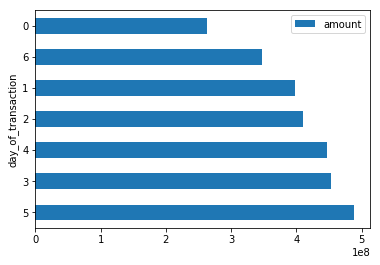

In [46]:
raw_df.groupby(['day_of_transaction']).sum()[['amount']].sort_values('amount', ascending = False ).plot(kind = 'barh')

In [47]:
a = '12OCT17:12:24:07'
date_datetime = datetime.datetime.strptime(a, '%d%b%y:%H:%M:%S' )

In [48]:
date_datetime.strftime('%w')
# действительно четверг
# day_0 - sunday

'4'

#### ожидаемо в пятницу больше всего активности, в воскресенье - меньше всего

In [49]:
day_target_1 = raw_df[(raw_df['target_flag'] == 1)].groupby(['day_of_transaction']).sum().sort_values('amount', 
                                                                                                      ascending=False).reset_index()
day_target_1

,day_of_transaction,cl_id,MCC,currency,amount,target_flag,target_sum,channel_type_new,MCC_new_4812,MCC_new_5712,MCC_new_5722,MCC_new_5732,MCC_new_7000
0,5,198265656,294303412,41816511,3.076744e+08,51579,1.293757e+10,36365.782837,207.0,162.0,190.0,296.0,50724.0
1,3,179321158,258822448,36750199,2.866410e+08,45372,1.112273e+10,31681.473268,183.0,155.0,204.0,296.0,44534.0
2,4,181949318,265766821,37609705,2.689972e+08,46451,1.133540e+10,32505.080109,185.0,163.0,199.0,256.0,45648.0
3,2,175435983,253938834,36030513,2.451088e+08,44483,1.104707e+10,31095.693295,213.0,147.0,217.0,191.0,43715.0
4,1,167538097,244703717,34728898,2.436032e+08,42858,1.049642e+10,30002.742048,189.0,146.0,163.0,237.0,42123.0
5,6,189041114,276188622,39250989,2.394749e+08,48444,1.300432e+10,34191.927936,176.0,323.0,302.0,349.0,47294.0
6,0,159338876,232825062,33167471,1.806225e+08,40916,9.879885e+09,28810.511342,155.0,286.0,273.0,256.0,39946.0


In [50]:
day_target_2 = raw_df[(raw_df['target_flag'] == 0)].groupby(['day_of_transaction']).sum().sort_values('amount', 
                                                                                                      ascending=False).reset_index()
day_target_2

,day_of_transaction,cl_id,MCC,currency,amount,target_flag,target_sum,channel_type_new,MCC_new_4812,MCC_new_5712,MCC_new_5722,MCC_new_5732,MCC_new_7000
0,5,177587458,156090151,22234115,1.812807e+08,0,0.0,15391.194848,251.0,121.0,154.0,215.0,26673.0
1,4,161810052,142270017,20278099,1.774940e+08,0,0.0,14001.537003,239.0,133.0,160.0,191.0,24284.0
2,3,156640700,137207715,19563608,1.665796e+08,0,0.0,13505.910769,221.0,139.0,163.0,190.0,23400.0
3,2,155962290,136846064,19498929,1.647440e+08,0,0.0,13447.341999,247.0,143.0,145.0,210.0,23281.0
4,1,149190153,131497182,18720636,1.550528e+08,0,0.0,12922.131779,199.0,137.0,125.0,205.0,22403.0
5,6,166333024,145330560,20763978,1.081479e+08,0,0.0,14311.873612,198.0,198.0,194.0,207.0,24786.0
6,0,137092019,120027457,17197096,8.207641e+07,0,0.0,11869.799154,194.0,162.0,178.0,172.0,20492.0


#### значимых отличий в динамике трат по дням неделе не найдено между target_flag

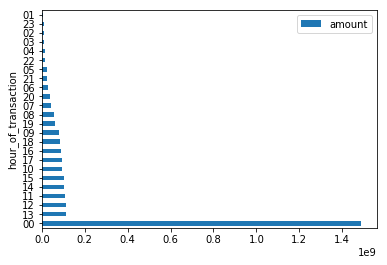

In [51]:
raw_df.groupby(['hour_of_transaction']).sum()[['amount']].sort_values('amount', ascending = False ).plot(kind = 'barh')

#### есть перекос в данных по времени 00, скорее всего это алгоритм банка. В таком виде данная переменная не информативна

In [177]:
#raw_df['date_of_transaction'] = raw_df['TRDATETIME'].apply(
     #   lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%y-%m-%d'))

In [178]:
#raw_df['date_of_transaction'] = raw_df['date_of_transaction'].apply(
   #     lambda x: (datetime.datetime.strptime(x, '%y-%m-%d')))

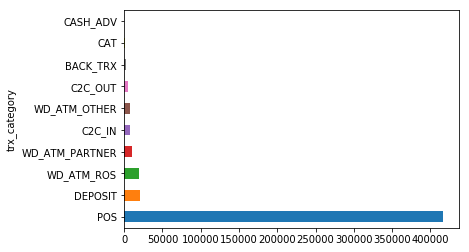

In [52]:
raw_df.groupby(['trx_category']).count()['cl_id'].sort_values(ascending = False).plot(kind = 'barh')

#### есть дисбаланс классов по количеству для POS, посмотрим по сумме

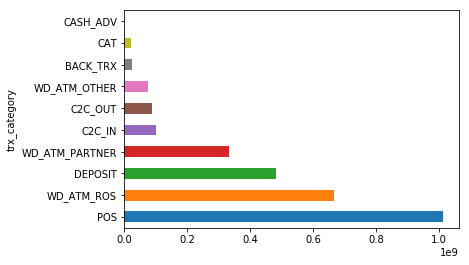

In [53]:
raw_df.groupby(['trx_category']).sum()['amount'].sort_values(ascending = False).plot(kind = 'barh')

стало лучше, также посмотрим вероятности по суммам

In [ ]:
# посмотрим на вероятность распределения по target_flag

In [54]:
trx_target = raw_df.groupby(['trx_category', 'target_flag']).sum()['amount']

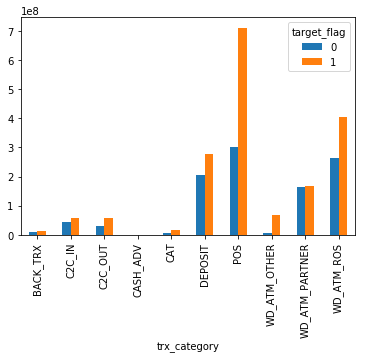

In [55]:
trx_target.unstack().plot(kind='bar')

выборку разделяют суммы по категориям POS, Deposit, WD_ATM_ROS, C2C_OUT, WD_ATM_OTHER

In [56]:
drop_column = ['MCC', 'channel_type', 'target_sum','hour_of_transaction', 
               'day_of_transaction', 'PERIOD', 'TRDATETIME', 'currency', 'MCC_new_7000']
raw_df.drop(drop_column, axis=1, inplace = True)

In [57]:
raw_df.head()

,cl_id,amount,trx_category,target_flag,channel_type_new,MCC_new_4812,MCC_new_5712,MCC_new_5722,MCC_new_5732
0,0,5023.0,POS,0,0.512154,0,0,0,0
1,0,20000.0,DEPOSIT,0,0.512154,0,0,0,0
2,0,767.0,POS,0,0.512154,0,0,0,0
3,0,2031.0,POS,0,0.512154,0,0,0,0
4,0,36562.0,C2C_OUT,0,0.512154,0,0,0,0


In [58]:
missingdata(raw_df)

,Total,Percent


In [59]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))


Total transactions in train dataset:  394139
Total transactions in test dataset:  96374


создаем агрегированные датасеты по cl_id

In [60]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [61]:
df_train_trx = get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='trx_category')


In [62]:
df_targets = raw_df[['cl_id', 'target_flag', 'channel_type_new']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1).reset_index()

In [63]:
df_amount = raw_df.groupby(['cl_id']).sum()['amount'].reset_index()

In [64]:
df_MCC_4812 = raw_df.groupby(['cl_id']).sum()['MCC_new_4812'].reset_index()

In [65]:
df_MCC_5712 = raw_df.groupby(['cl_id']).sum()['MCC_new_5712'].reset_index()

In [66]:
df_MCC_5722 = raw_df.groupby(['cl_id']).sum()['MCC_new_5722'].reset_index()

In [67]:
df_MCC_5732 = raw_df.groupby(['cl_id']).sum()['MCC_new_5732'].reset_index()

In [68]:
df_count_trx = raw_df.groupby(['cl_id']).count()['amount'].reset_index()

In [69]:
df_cpart = df_amount.merge(df_MCC_4812, on = 'cl_id', how = 'left')
df_cpart = df_cpart.merge(df_MCC_5712, on = 'cl_id', how = 'left')
df_cpart = df_cpart.merge(df_MCC_5722, on = 'cl_id', how = 'left')
df_cpart = df_cpart.merge(df_MCC_5732, on = 'cl_id', how = 'left')
df_cpart = df_cpart.merge(df_count_trx, on = 'cl_id', how = 'left')
df_cpart = df_cpart.merge(df_targets, on = 'cl_id', how = 'left')

df_cpart.index = df_cpart['cl_id']
df_cpart_f = df_cpart.drop('cl_id', axis=1)

In [70]:
df_train = pd.merge(
    df_train_trx,
    df_cpart_f,
    left_index=True,
    right_index=True,
    how='inner'
)

In [71]:
df_train.head()

,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS,amount_x,MCC_new_4812,MCC_new_5712,MCC_new_5722,MCC_new_5732,amount_y,target_flag,channel_type_new
cl_id,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0,267578.04,0,0,0,0,104,0,0.512154
5,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0,546369.13,0,0,1,0,142,1,0.512154
9,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0,849315.09,0,0,0,0,39,0,0.512154
10,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0,1124343.99,1,0,1,1,463,0,0.512154
11,0.0,0.0,0.00,0.0,0.00,182000.0,245747.14,0.0,0.0,0.0,427747.14,0,2,1,2,217,0,0.512154


In [72]:
# оставляем только категории POS, Deposit, WD_ATM_ROS, C2C_OUT, WD_ATM_OTHER

drop_column_1 = ['trx_category_sum_BACK_TRX', 'trx_category_sum_C2C_IN', 'trx_category_sum_CASH_ADV','trx_category_sum_CAT', 
               'trx_category_sum_WD_ATM_PARTNER']
df_train.drop(drop_column_1, axis=1, inplace = True)

In [73]:
# создаем как планировали переменную MCC_ для классификации флага 0
df_train['MCC_'] = df_train['MCC_new_4812'] + df_train['MCC_new_5712'] + df_train['MCC_new_5722'] + df_train['MCC_new_5732']

In [74]:
# test
df_test_trx = get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='trx_category')

In [75]:
df_test = pd.merge(
    df_test_trx,
    df_cpart_f,
    left_index=True,
    right_index=True,
    how='inner'
)

In [76]:
df_test.drop(drop_column_1, axis=1, inplace = True)

In [77]:
df_test['MCC_'] = df_test['MCC_new_4812'] + df_test['MCC_new_5712'] + df_test['MCC_new_5722'] + df_test['MCC_new_5732']

готвим данные для обучения и тестирования модели

In [78]:
X_test = df_test.drop(['target_flag'], axis=1)
y_test = df_test['target_flag']

In [79]:
X_train = df_train.drop(['target_flag'], axis=1)
y_train = df_train['target_flag']

Используем для обучения модель RandomForestClassifier

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [81]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [82]:
cols

['trx_category_sum_C2C_OUT',
 'trx_category_sum_DEPOSIT',
 'trx_category_sum_POS',
 'trx_category_sum_WD_ATM_OTHER',
 'trx_category_sum_WD_ATM_ROS',
 'amount_x',
 'MCC_new_4812',
 'MCC_new_5712',
 'MCC_new_5722',
 'MCC_new_5732',
 'amount_y',
 'channel_type_new',
 'MCC_']

In [200]:
# обучаем модель
clf = RandomForestClassifier(n_estimators=57, max_depth=10, random_state=0)\
.fit(X_train[cols], y_train)

In [201]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 4)
print("Train: ", roc_auc_train)

Train:  0.9324


In [202]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]

roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Test: ", roc_auc_test)

Test:  0.8103


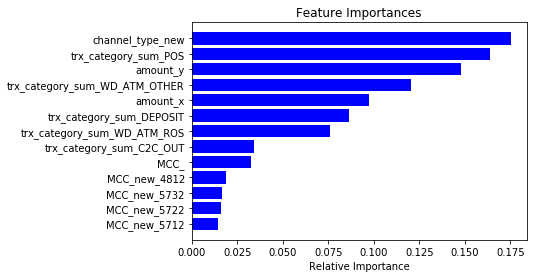

In [159]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

действительно MCC_  лучше разделяет по target_flag, чем каждая МСС_new_ по отдельности

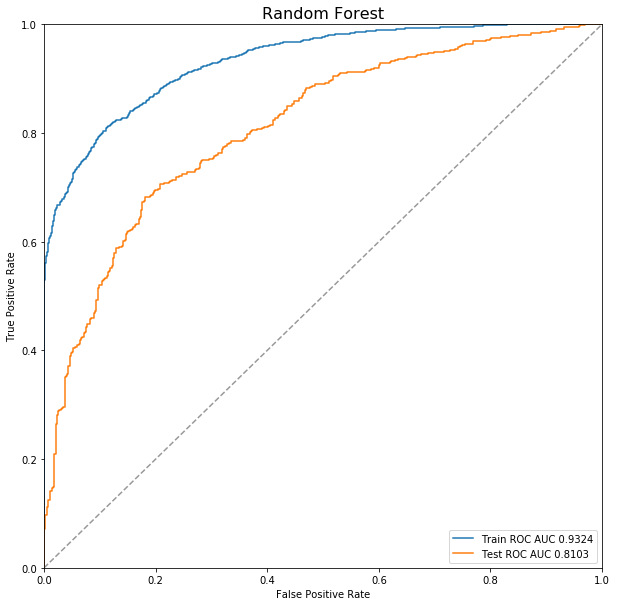

In [160]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest', size=16)
plt.legend(loc='lower right')
plt.show()

In [206]:
from IPython.display import Image

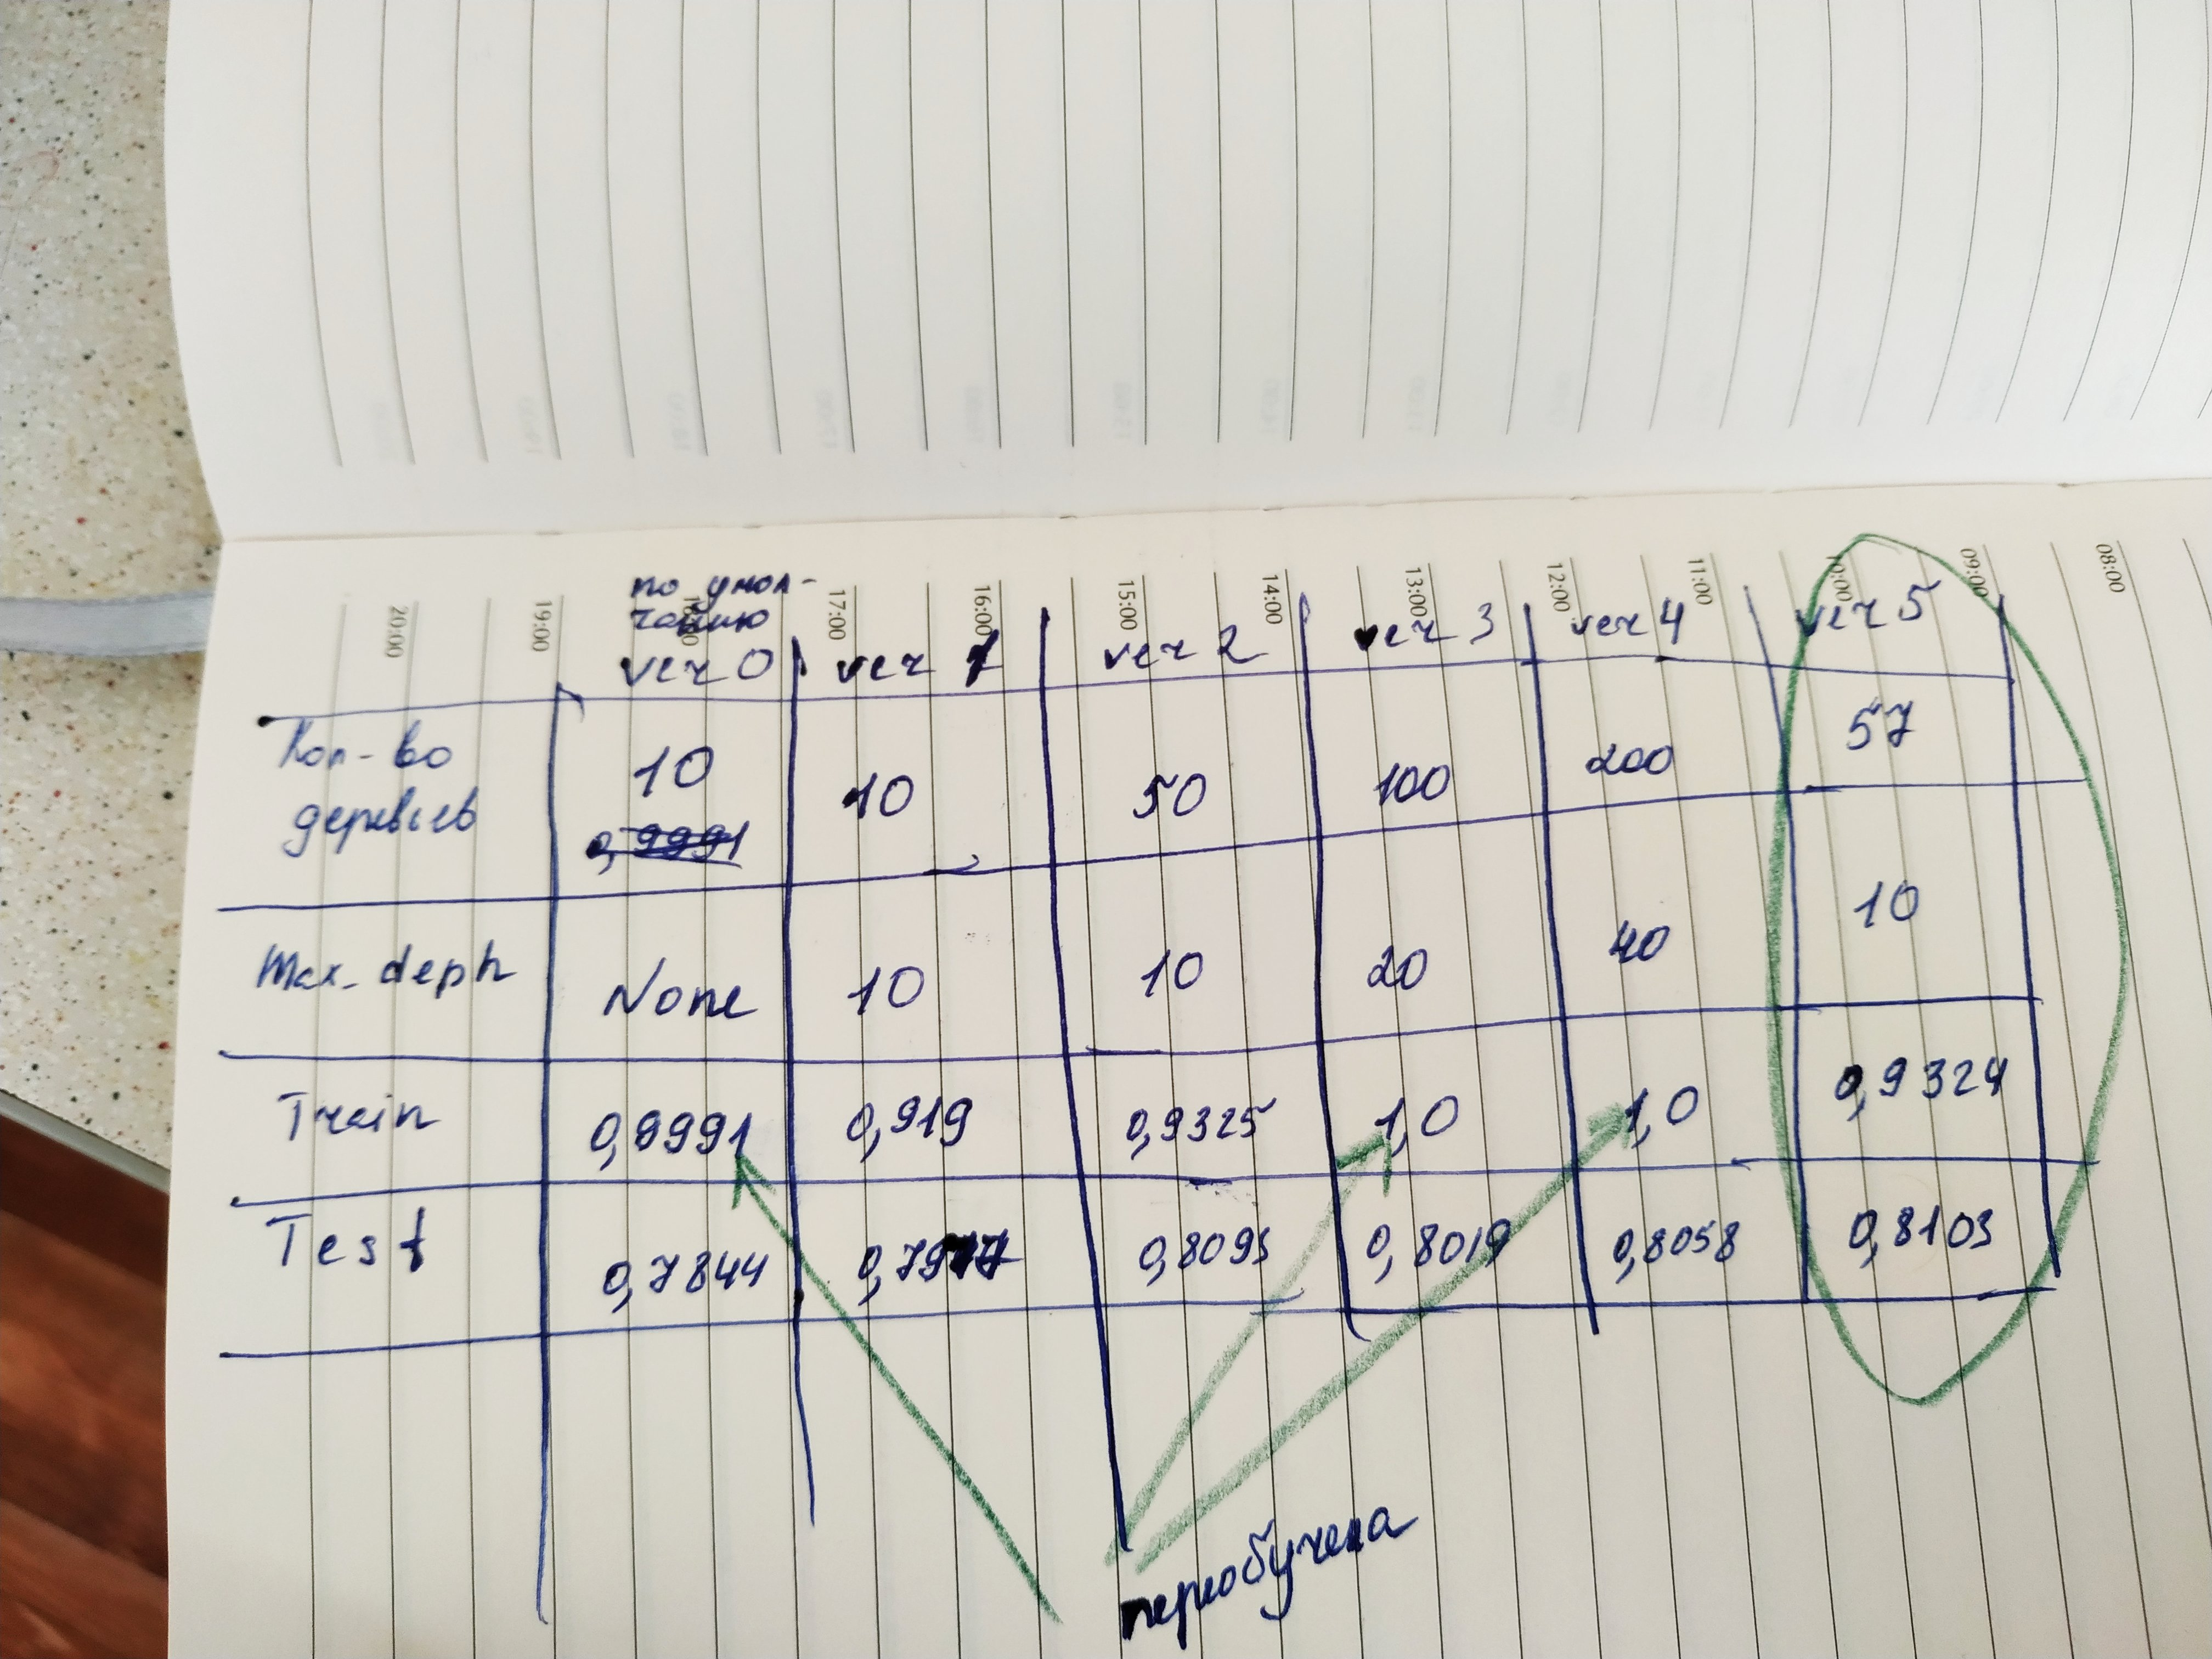

In [207]:
Image('for_dz24.jpg')

Проверим на модели XGBClassifier

In [203]:
xgb = xgboost.XGBClassifier(max_depth=3, n_jobs=-1)

xgb.fit(X_train, y_train)
y_train_predict = xgb.predict_proba(X_train)[:, 1]
y_test_predict = xgb.predict_proba(X_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 4)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.8523
Test:  0.813


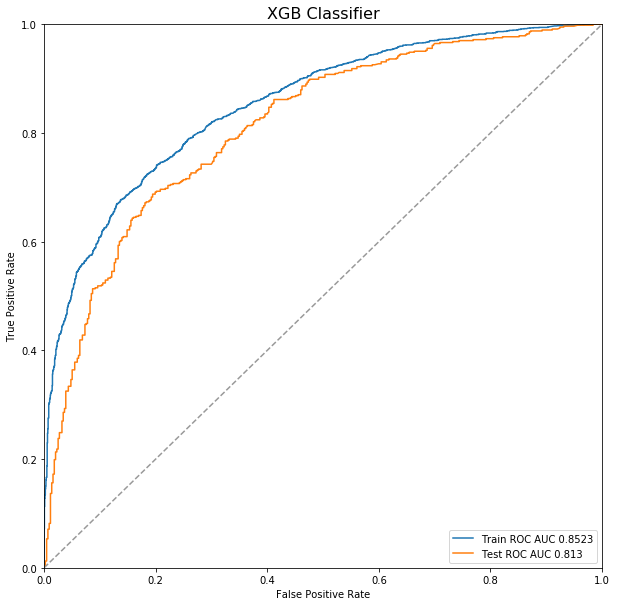

In [204]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

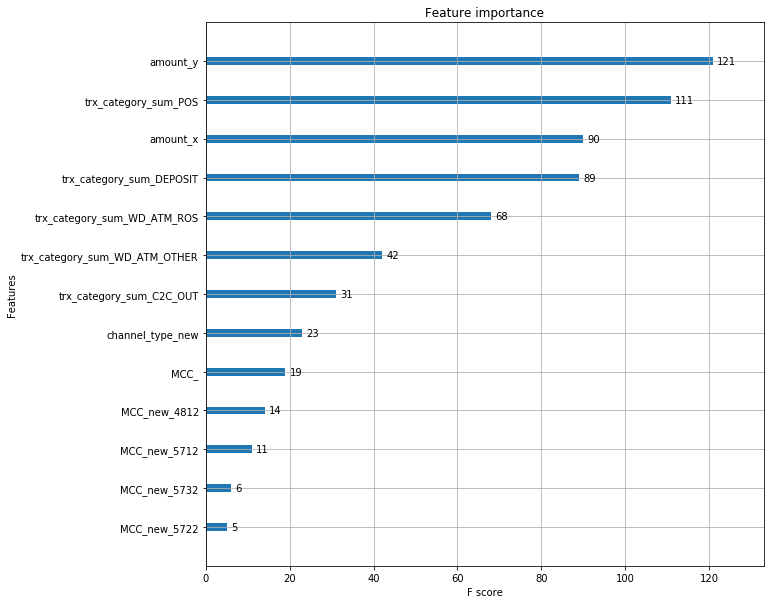

In [205]:
plt.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')

# amount_y  - кол-во транзакций

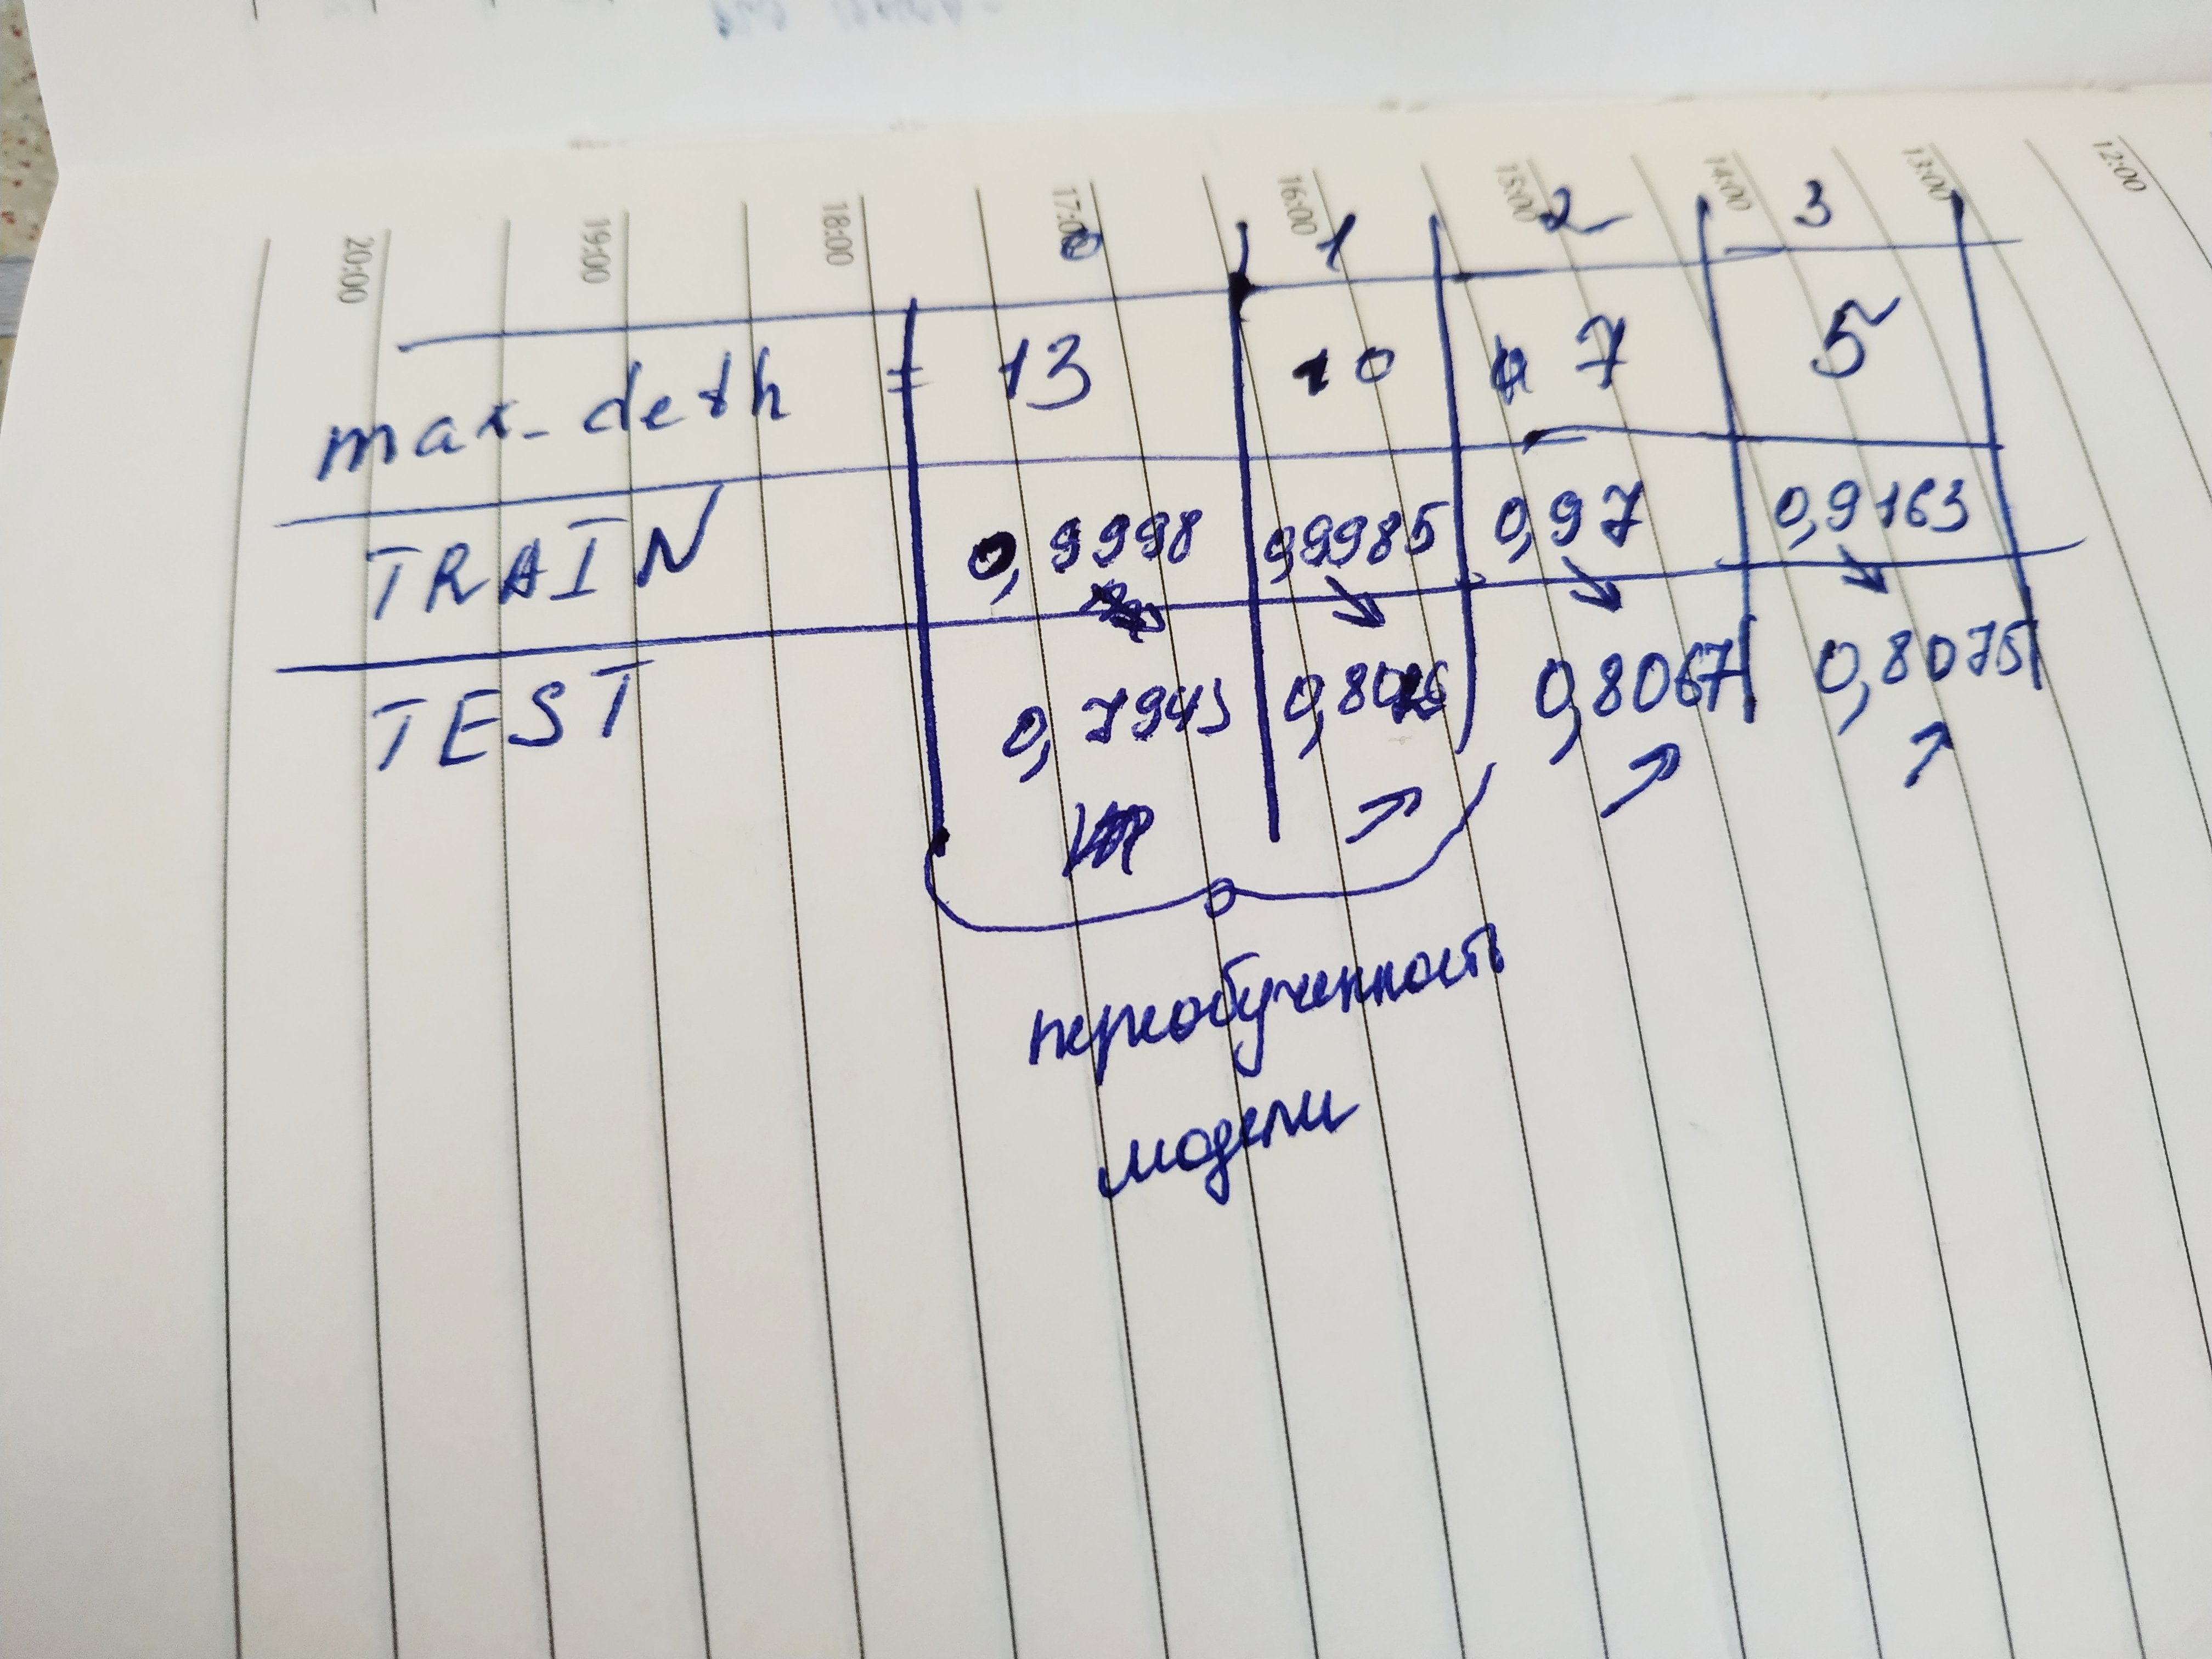

In [208]:
Image('dz24_xgb.jpg')

в xgbclassifier channel_type_new оказалось внизу, а в Random Forest наоборот лучшей